## Overview

Given PCA coordinates generate a figure that captures the main structure identified.

In [1]:
import gcsfs
import zarr
import intake
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

In [2]:
import allel

In [3]:
from ag3 import release_data
v3 = release_data()

In [4]:
# Data storage, uses about 34 MB
pca_cloud_zarr_path_template = 'vo_agam_production/ag3_data_paper/{}.pca_output.zarr'
# Writing the PCA data to the cloud will require the appropriate authentication and authorization.

import gcsfs
# UNCOMMENT THIS TO AUTHENTICATE. YOU ONLY NEED TO RUN THIS ONCE.
# After running this once, your authentication token should then be cached in `~/.gcs_tokens`
# Once you have authenticated, you should comment this out again to avoid re-authenticating.
# gcs_browser = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='browser')

# Use `cache_timeout=0` to prevent object list cache, to avoid recreating map for Zarr consolidated metadata
auth_fs = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='cache', cache_timeout=0)

In [5]:
pca_cloud_zarr_path = pca_cloud_zarr_path_template.format('gamb_colu')
pca_cloud_zarr_path

'vo_agam_production/ag3_data_paper/gamb_colu.pca_output.zarr'

In [6]:
# Sometimes errors with `overwrite=True`, sometimes errors without, when dir not exist
# Keep the zarr_store for zarr.consolidate_metadata(zarr_store)
zarr_store = auth_fs.get_mapper(pca_cloud_zarr_path)
zarr_group = zarr.group(zarr_store)

In [7]:
list(zarr_group.keys())

['components', 'coords', 'explained_variance_ratio', 'sample_names']

In [8]:
sample_names = zarr_group["sample_names"][:]
sample_names = [s.decode() for s in sample_names]

In [9]:
pca_coordinates = zarr_group["coords"]
pca_components = zarr_group["components"]
pca_pve = zarr_group["explained_variance_ratio"]

In [10]:
list(zarr_group.keys())

['components', 'coords', 'explained_variance_ratio', 'sample_names']

In [11]:
all_meta = v3.load_sample_set_metadata(v3.all_wild_sample_sets)

/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
/opt/conda/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


In [12]:
all_meta.columns

Index(['partner_sample_id', 'contributor', 'country', 'location', 'year',
       'month', 'latitude', 'longitude', 'sex_call', 'sample_set',
       'aim_fraction_colu', 'aim_fraction_arab', 'species_gambcolu_arabiensis',
       'species_gambiae_coluzzii', 'is_arabiensis', 'is_gamb_colu',
       'is_gambiae', 'is_coluzzii'],
      dtype='object')

In [13]:
df_species_samples = all_meta.loc[sample_names]
df_species_samples.head()

,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,sample_set,aim_fraction_colu,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii,is_arabiensis,is_gamb_colu,is_gambiae,is_coluzzii
sample_id,,,,,,,,,,,,,,,,,,
AR0047-C,LUA047,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.945,0.001,gamb_colu,coluzzii,False,True,False,True
AR0049-C,LUA049,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.933,0.001,gamb_colu,coluzzii,False,True,False,True
AR0051-C,LUA051,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.937,0.002,gamb_colu,coluzzii,False,True,False,True
AR0061-C,LUA061,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.938,0.002,gamb_colu,coluzzii,False,True,False,True
AR0078-C,LUA078,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.926,0.001,gamb_colu,coluzzii,False,True,False,True


In [14]:
color_lookup = pd.DataFrame([(k, a, b)  for k, v in v3.population_colours.items() for a, b in v.items()], columns=["country", "location", "colorhex"])

In [15]:
df_species_samples = df_species_samples.merge(color_lookup, how="left")

In [16]:
components = np.arange(8, dtype=np.int8).reshape((2, 2, 2))
components

array([[[0, 1],
        [2, 3]],

       [[4, 5],
        [6, 7]]], dtype=int8)

In [17]:
import seaborn as sns

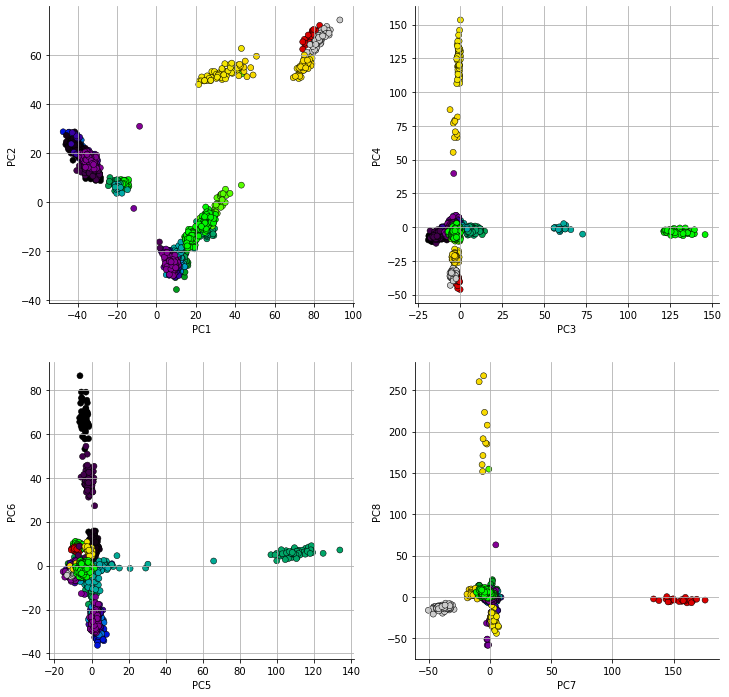

In [18]:
f, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))


for ix in range(2):
        
    for jx in range(2):
            
        component_a, component_b = components[ix][jx]
        ax = axes[ix, jx]

        ax.scatter(pca_coordinates[:, component_a], pca_coordinates[:, component_b], c=df_species_samples.colorhex, edgecolor='k', lw=0.5)
        ax.grid(True)
        ax.set_xlabel(f"PC{component_a + 1}")
        ax.set_ylabel(f"PC{component_b + 1}")
        sns.despine(ax=ax)

f.savefig("../content/images/pca/gamb_colu.svg", dpi=200)

## Display mapping of locations to colours

This to be deleted when moved to other notebook,

In [28]:
g = df_species_samples.drop_duplicates(subset="geog_values")
g = g.sort_values("geog_values")
g.shape

(121, 19)

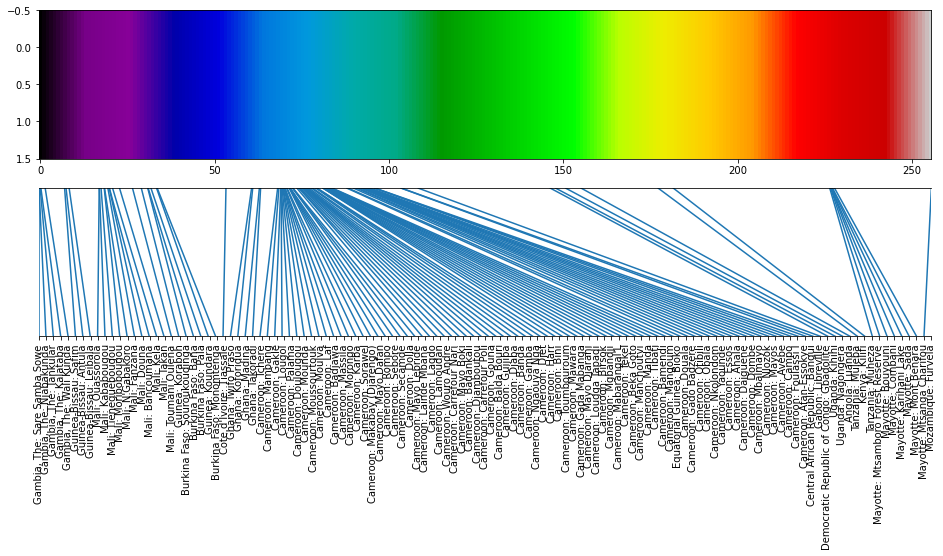

In [29]:
fig, axes = plt.subplots(nrows=2, figsize=(16, 6))

ax1, ax2 = axes

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

ax1.imshow(gradient, aspect='auto', cmap=plt.get_cmap(cmap_name))

# for i, row in g.reset_index().iterrows():
#     v = row.geog_values
#     label = f"{row.country}: {row.location}"

labels = g.apply(lambda row: f"{row.country}: {row.location}", axis=1).values

allel.plot_variant_locator(g.geog_values.values, ax=ax2, flip=True)
ax2.xaxis.tick_bottom()

_ = ax2.set_xticks(np.linspace(0, 1, g.shape[0]))
_ = ax2.set_xticklabels(labels, rotation=90)
#ax3.set_xlim(0, 1)

## Attempt Bokeh

In [30]:
# let's try bokeh...
# imports required for `bokeh`
from bokeh.plotting import figure, show, ColumnDataSource, output_file
from bokeh.layouts import gridplot

In [76]:
import matplotlib as mpl

def plot_pca_coords(coords, pve, pc1, pc2, fig, df, group_var, col_dict="auto", query=None):

    x = coords[:, pc1]
    y = coords[:, pc2]
    
    qdf = df.reset_index().copy()
    qdf["x"] = x
    qdf["y"] = y
    
    # apply_query
    if query is not None:
        qdf = qdf.query(query)
    
    g = qdf.groupby(group_var)
    
    if col_dict == "auto":
        cp = sns.color_palette(n_colors=len(g))
        col_dict = {k:v for k, v in zip(g.groups, cp)}
        
    for label, frame in g:
        
        source = ColumnDataSource(data=frame)
        
        fig.circle(
            'x', 'y', 
            source=source,
            line_color='black',
            line_width=0.5,
            size=6,
            fill_color=mpl.colors.rgb2hex(col_dict[label]))
    
    fig.xaxis.axis_label = 'PC {0} ({1:.2f}%)'.format(
        pc1 + 1, 100 * pve[pc1])
    
    fig.yaxis.axis_label = 'PC {0} ({1:.2f}%)'.format(
        pc2 + 1, 100 * pve[pc2])
    
    return fig

In [72]:
df_species_samples.head()

,location_label,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,sample_set,aim_fraction_colu,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii,is_arabiensis,is_gamb_colu,is_gambiae,is_coluzzii,geog_values
sample_id,,,,,,,,,,,,,,,,,,,,
AR0047-C,group109,LUA047,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.945,0.001,gamb_colu,coluzzii,False,True,False,True,0.590414
AR0049-C,group109,LUA049,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.933,0.001,gamb_colu,coluzzii,False,True,False,True,0.590414
AR0051-C,group109,LUA051,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.937,0.002,gamb_colu,coluzzii,False,True,False,True,0.590414
AR0061-C,group109,LUA061,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.938,0.002,gamb_colu,coluzzii,False,True,False,True,0.590414
AR0078-C,group109,LUA078,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,0.926,0.001,gamb_colu,coluzzii,False,True,False,True,0.590414


In [77]:
# This defines what is displayed when the mouse hovers over a point.
# The @ values correspond to values in the table.
TOOLTIPS = [
    ("ox_code", "@sample_id"),
    ("country", "@country"),
    ("location", "@location"),
    ("collection year", "@year"),
    ("species", "@species_gambcolu_arabiensis"),
    ("species_gamcol", "@species_gambiae_coluzzii"),
    ("(x, y)", "($x, $y)"),]

In [78]:
components = np.array(range(8)).reshape((2, 2, 2)).tolist()

In [79]:
qlabel = pd.Series(data="", index=cs.index, name="qlabel")
qlabel

sample_id
AR0047-C     
AR0049-C     
AR0051-C     
AR0061-C     
AR0078-C     
           ..
AC0295-C     
AC0296-C     
AC0297-C     
AC0298-C     
AC0299-C     
Name: qlabel, Length: 2784, dtype: object

In [80]:
i = 0
for q, z in cs.groupby(0).groups.items():
    qlabel.loc[z] = f"group{i}"
    i += 1

In [81]:
f = pd.concat([qlabel, cs], axis=1).set_index("qlabel").drop_duplicates()
f = pd.DataFrame(plt.get_cmap(cmap_name)(f[0]), index=f.index)
pop_colours = {s: x.values for s, x in f.iterrows()}

In [82]:
try:
    df_species_samples.insert(0, "location_label", qlabel.loc[sample_names])
except ValueError:
    pass

In [164]:
qq = 'country in ("Gambia, The", "Guinea-Bissau")'
qq = 'country in ("Mozambique", "Kenya")'
qq = 'country in ("Tanzania", "Kenya")'
qq = 'country in ("Mayotte")'
qq = 'country in ("Angola", "Uganda", "Gabon", "Democratic Republic of Congo", "Central African Republic")'

In [165]:
output_file("pca_plots.html")
grid = []

for row in components:
    
    l = []
    
    for (c1, c2) in row:

        p = figure(plot_width=400, plot_height=400, tooltips=TOOLTIPS)
        l.append(
            plot_pca_coords(
                pca_coordinates, 
                pca_pve, 
                c1, 
                c2, 
                p,
                df_species_samples,
                "location",
                col_dict="auto",
                query=qq))
                #"location_label"))
        
    grid.append(l)

col = gridplot(grid)
show(col)

In [166]:
df_species_samples.query(qq).groupby("location").first()

,location_label,partner_sample_id,contributor,country,year,month,latitude,longitude,sex_call,sample_set,...,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii,is_arabiensis,is_gamb_colu,is_gambiae,is_coluzzii,geog_values,PC1,PC2
location,,,,,,,,,,,,,,,,,,,,,
Bangui,group104,RCA_1,Alessandra della Torre,Central African Republic,1993,12,4.367,18.583,F,AG1000G-CF,...,0.002,gamb_colu,gambiae,False,True,True,False,0.406188,8.234481,-24.744617
Gbadolite,group106,Gba_1_9,David Weetman,Democratic Republic of Congo,2015,7,4.283,21.017,M,AG1000G-CD,...,0.002,gamb_colu,gambiae,False,True,True,False,0.425337,10.105502,-26.148556
Kihihi,group107,K1,Martin Donnelly,Uganda,2012,10,-0.751,29.701,F,AG1000G-UG,...,0.003,gamb_colu,gambiae,False,True,True,False,0.573228,27.598177,-6.377851
Libreville,group105,LIB001,Joao Pinto,Gabon,2000,12,0.384,9.455,F,AG1000G-GA-A,...,0.001,gamb_colu,gambiae,False,True,True,False,0.406611,23.716730,-9.680986
Luanda,group109,LUA047,Joao Pinto,Angola,2009,4,-8.884,13.302,F,AG1000G-AO,...,0.001,gamb_colu,coluzzii,False,True,False,True,0.590414,-16.402231,8.965208
Nagongera,group108,1_A1,Martin Donnelly,Uganda,2012,10,0.770,34.026,F,AG1000G-UG,...,0.002,gamb_colu,gambiae,False,True,True,False,0.579183,20.098331,-14.245767


In [183]:
df_species_samples.query("country == 'Mali'").species_gambiae_coluzzii.value_counts()

gambiae         131
coluzzii         91
intermediate      1
Name: species_gambiae_coluzzii, dtype: int64

In [93]:
df_species_samples.country.value_counts()

Cameroon                        442
Burkina Faso                    293
Gambia, The                     279
Mali                            223
Uganda                          207
Guinea                          136
Guinea-Bissau                   101
Ghana                           100
Angola                           81
Cote d'Ivoire                    80
Democratic Republic of Congo     76
Tanzania                         75
Mozambique                       74
Central African Republic         73
Kenya                            73
Gabon                            69
Mayotte                          23
Equatorial Guinea                10
Name: country, dtype: int64

In [170]:
g = df_species_samples.query(qq).groupby("location")

In [171]:
g.first()

,location_label,partner_sample_id,contributor,country,year,month,latitude,longitude,sex_call,sample_set,...,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii,is_arabiensis,is_gamb_colu,is_gambiae,is_coluzzii,geog_values,PC1,PC2
location,,,,,,,,,,,,,,,,,,,,,
Bangui,group104,RCA_1,Alessandra della Torre,Central African Republic,1993,12,4.367,18.583,F,AG1000G-CF,...,0.002,gamb_colu,gambiae,False,True,True,False,0.406188,8.234481,-24.744617
Gbadolite,group106,Gba_1_9,David Weetman,Democratic Republic of Congo,2015,7,4.283,21.017,M,AG1000G-CD,...,0.002,gamb_colu,gambiae,False,True,True,False,0.425337,10.105502,-26.148556
Kihihi,group107,K1,Martin Donnelly,Uganda,2012,10,-0.751,29.701,F,AG1000G-UG,...,0.003,gamb_colu,gambiae,False,True,True,False,0.573228,27.598177,-6.377851
Libreville,group105,LIB001,Joao Pinto,Gabon,2000,12,0.384,9.455,F,AG1000G-GA-A,...,0.001,gamb_colu,gambiae,False,True,True,False,0.406611,23.716730,-9.680986
Luanda,group109,LUA047,Joao Pinto,Angola,2009,4,-8.884,13.302,F,AG1000G-AO,...,0.001,gamb_colu,coluzzii,False,True,False,True,0.590414,-16.402231,8.965208
Nagongera,group108,1_A1,Martin Donnelly,Uganda,2012,10,0.770,34.026,F,AG1000G-UG,...,0.002,gamb_colu,gambiae,False,True,True,False,0.579183,20.098331,-14.245767


In [ ]:
plt.scatter(df_species_samples.longitude, df_species_samples.latitude, c=plot_colors)

In [ ]:
# broadly speaking in an E/W plane.

# 


In [ ]:
# https://stackoverflow.com/questions/31967472/smooth-interpolated-tertiary-or-quaternary-colour-scales-e-g-r-g-b-triangle

## Population definitions

Populations must be disjoint!

In [102]:
df_species_samples["PC1"] = pca_coordinates[:, 0]
df_species_samples["PC2"] = pca_coordinates[:, 1]

definition_file = "../content/population_definitions.yml"

In [124]:
population_definitions = {}

In [125]:
df_species_samples.columns

Index(['location_label', 'partner_sample_id', 'contributor', 'country',
       'location', 'year', 'month', 'latitude', 'longitude', 'sex_call',
       'sample_set', 'aim_fraction_colu', 'aim_fraction_arab',
       'species_gambcolu_arabiensis', 'species_gambiae_coluzzii',
       'is_arabiensis', 'is_gamb_colu', 'is_gambiae', 'is_coluzzii',
       'geog_values', 'PC1', 'PC2'],
      dtype='object')

### Gulf west Africa

In [126]:
population_definitions["GM_col"] = df_species_samples.query(
    "country == 'Gambia, The'").query(
        "species_gambiae_coluzzii == 'coluzzii'").index.values.tolist()

population_definitions["GM_im"] = df_species_samples.query(
    "country == 'Gambia, The'").query(
        "species_gambiae_coluzzii != 'coluzzii'").query(
            "PC1 < 0").index.values.tolist()

assert set(population_definitions["GM_im"]).isdisjoint(population_definitions["GM_col"])

population_definitions["GW_im"] = df_species_samples.query(
    "country == 'Guinea-Bissau'").query(
        "PC1 < 0").index.values.tolist()

population_definitions["GW_gam"] = df_species_samples.query(
    "country == 'Guinea-Bissau'").query(
        "PC1 > 0").index.values.tolist()

### East Africa


# mozambique gambiae all one cluster, but similar to KE 2000


In [138]:
population_definitions["MZ_gam"] = df_species_samples.query(
    "country == 'Mozambique'").query(
        "species_gambiae_coluzzii == 'gambiae'").index.values.tolist()

In [146]:
df_species_samples.query(
    "country == 'Kenya'").query(
        "year == 2000").species_gambiae_coluzzii.value_counts()

gambiae    19
Name: species_gambiae_coluzzii, dtype: int64

In [144]:
# KE gambiae 2000 one cluster, but similar to MZ
population_definitions["KE_gam"] = df_species_samples.query(
    "country == 'Kenya'").query(
        "year == 2000").index.values.tolist()

['AK0177-C',
 'AK0203-C',
 'AK0207-C',
 'AK0211-C',
 'AK0212-C',
 'AK0213-C',
 'AK0214-C',
 'AK0215-C',
 'AK0226-C',
 'AK0235-C',
 'AK0236-C',
 'AK0237-C',
 'AK0238-C',
 'AK0239-C',
 'AK0274-C',
 'AK0278-C',
 'AK0279-C',
 'AK0280-C',
 'AK0281-C']

In [148]:
population_definitions["KE_im"] = df_species_samples.query(
    "country == 'Kenya'").query(
        "year == 2012").index.values.tolist()

population_definitions["TZ_gam_1"] = df_species_samples.query(
    "country == 'Tanzania'").query(
    "location == 'Muleba'").query(
    "PC2 < 10").index.values.tolist()

population_definitions["TZ_gam_2"] = df_species_samples.query(
    "country == 'Tanzania'").query(
    "location == 'Muheza'").query(
    "PC1 > 65").index.values.tolist()

population_definitions["TZ_im"] = df_species_samples.query(
    "country == 'Tanzania'").query(
    "PC1 < 55").query(
    "PC2 > 40").index.values.tolist()

In [162]:
population_definitions["MY_gam"] = df_species_samples.query(
    "country == 'Mayotte'").index.values.tolist()

df_species_samples.loc[population_definitions["MY_gam"]].species_gambiae_coluzzii.value_counts()

gambiae    23
Name: species_gambiae_coluzzii, dtype: int64

In [163]:
df_species_samples.country.value_counts()

Cameroon                        442
Burkina Faso                    293
Gambia, The                     279
Mali                            223
Uganda                          207
Guinea                          136
Guinea-Bissau                   101
Ghana                           100
Angola                           81
Cote d'Ivoire                    80
Democratic Republic of Congo     76
Tanzania                         75
Mozambique                       74
Central African Republic         73
Kenya                            73
Gabon                            69
Mayotte                          23
Equatorial Guinea                10
Name: country, dtype: int64

## Central-ish Africa

In [167]:
population_definitions["CA_gam"] = df_species_samples.query(
    "country == 'Central African Republic'").query(
        "species_gambiae_coluzzii == 'gambiae'").index.values.tolist()

df_species_samples.loc[population_definitions["CA_gam"]].species_gambiae_coluzzii.value_counts()

gambiae    55
Name: species_gambiae_coluzzii, dtype: int64

In [168]:
population_definitions["CA_col"] = df_species_samples.query(
    "country == 'Central African Republic'").query(
        "species_gambiae_coluzzii == 'coluzzii'").index.values.tolist()

df_species_samples.loc[population_definitions["CA_col"]].species_gambiae_coluzzii.value_counts()

coluzzii    18
Name: species_gambiae_coluzzii, dtype: int64

In [169]:
population_definitions["UG_gam_1"] = df_species_samples.query(
    "location == 'Nagongera'").index.values.tolist()

df_species_samples.loc[population_definitions["UG_gam_1"]].species_gambiae_coluzzii.value_counts()

gambiae    112
Name: species_gambiae_coluzzii, dtype: int64

In [172]:
population_definitions["UG_gam_2"] = df_species_samples.query(
    "location == 'Kihihi'").index.values.tolist()

df_species_samples.loc[population_definitions["UG_gam_2"]].species_gambiae_coluzzii.value_counts()

gambiae    95
Name: species_gambiae_coluzzii, dtype: int64

In [173]:
population_definitions["GA_gam"] = df_species_samples.query(
    "location == 'Libreville'").index.values.tolist()

df_species_samples.loc[population_definitions["GA_gam"]].species_gambiae_coluzzii.value_counts()

gambiae    69
Name: species_gambiae_coluzzii, dtype: int64

In [174]:
population_definitions["DR_gam"] = df_species_samples.query(
    "location == 'Gbadolite'").index.values.tolist()

df_species_samples.loc[population_definitions["DR_gam"]].species_gambiae_coluzzii.value_counts()

gambiae    76
Name: species_gambiae_coluzzii, dtype: int64

In [175]:
population_definitions.keys()

dict_keys(['GM_col', 'GM_im', 'GW_im', 'GW_gam', 'MZ_gam', 'KE_gam', 'KE_im', 'TZ_gam_1', 'TZ_gam_2', 'TZ_im', 'MY_gam', 'CA_gam', 'CA_col', 'UG_gam_1', 'UG_gam_2', 'GA_gam', 'DR_gam'])

In [176]:
from itertools import combinations
import yaml

## Check and write to file

Need to ensure all populations are disjoint

In [177]:
for a, b in combinations(population_definitions.keys(), 2):
    
    set1 = set(population_definitions[a])
    set2 = set(population_definitions[b])
    print(f"Checking {a} vs {b}")
    assert set1.isdisjoint(set2), f"{a} and {b} are not disjoint. Share {set1.intersection(set2)}"
    

with open(definition_file, mode="w") as wr:
    print(yaml.dump(population_definitions), file=wr)

Checking GM_col vs GM_im
Checking GM_col vs GW_im
Checking GM_col vs GW_gam
Checking GM_col vs MZ_gam
Checking GM_col vs KE_gam
Checking GM_col vs KE_im
Checking GM_col vs TZ_gam_1
Checking GM_col vs TZ_gam_2
Checking GM_col vs TZ_im
Checking GM_col vs MY_gam
Checking GM_col vs CA_gam
Checking GM_col vs CA_col
Checking GM_col vs UG_gam_1
Checking GM_col vs UG_gam_2
Checking GM_col vs GA_gam
Checking GM_col vs DR_gam
Checking GM_im vs GW_im
Checking GM_im vs GW_gam
Checking GM_im vs MZ_gam
Checking GM_im vs KE_gam
Checking GM_im vs KE_im
Checking GM_im vs TZ_gam_1
Checking GM_im vs TZ_gam_2
Checking GM_im vs TZ_im
Checking GM_im vs MY_gam
Checking GM_im vs CA_gam
Checking GM_im vs CA_col
Checking GM_im vs UG_gam_1
Checking GM_im vs UG_gam_2
Checking GM_im vs GA_gam
Checking GM_im vs DR_gam
Checking GW_im vs GW_gam
Checking GW_im vs MZ_gam
Checking GW_im vs KE_gam
Checking GW_im vs KE_im
Checking GW_im vs TZ_gam_1
Checking GW_im vs TZ_gam_2
Checking GW_im vs TZ_im
Checking GW_im vs MY_ga